In [1]:
from simulation import RecSys, Patient, Protocol, Session, Simulator
from typing import Dict, List
import time
import random
import logging
import numpy as np

logging.disable(logging.CRITICAL) # Mute all logs below CRITICAL

1. Initialize Patients & Protocols and run simulation

In [4]:
# 1. Define protocols
possible_dms = ["Speed", "Size", "Length", "Accuracy", "Strength", "Endurance"]
num_protocols = 15
protocols = []
for i in range(1, num_protocols+1):  # Sequential IDs from 1 to 20
    dms = random.sample(possible_dms, random.randint(2, 5))  # Sample 2-5 dms
    ar = random.choice([True, False])  # 50% chance for ar
    protocol = Protocol(
        id=f"{i}",
        name=f"Protocol {chr(64 + i)}",  # Names like "Protocol A", "Protocol B", etc.
        dms=dms,
        ar=ar
    )
    protocols.append(protocol)

# 2. Define ground truth for DMs
def generate_random_ground_truth(protocols: List[Protocol], low: int = 0.8, high: int = 0.9):
    ground_truth: Dict[str, List[float]] = {}
    for protocol in protocols:
        # Generate target DM values based on the number of DMs in the protocol
        target_dms = [round(random.uniform(low, high), 2) for _ in protocol.dms]
        ground_truth[str(protocol.id)] = target_dms
    return ground_truth

# 3. Initialize a patient
# patients = []
# for i in range(1, 2):  # Create 10 patients
#     patient = Patient(dm_ground_truth=generate_random_ground_truth(protocols))
#     patients.append(patient)
import copy
patient1 = Patient(dm_ground_truth=generate_random_ground_truth(protocols))
patient2 = copy.deepcopy(patient1)

# 4. Create a recommender system
recsys = RecSys(protocols=protocols)

# # 5. Simulate sessions
simulation = Simulator(recsys)
num_days = 501
for day in range(0, num_days+1):
    simulation.use_recommendations(patient1)
    simulation.use_random(patient2)

# Recommender Dynamics

1. Protocol Recommendation Distribution

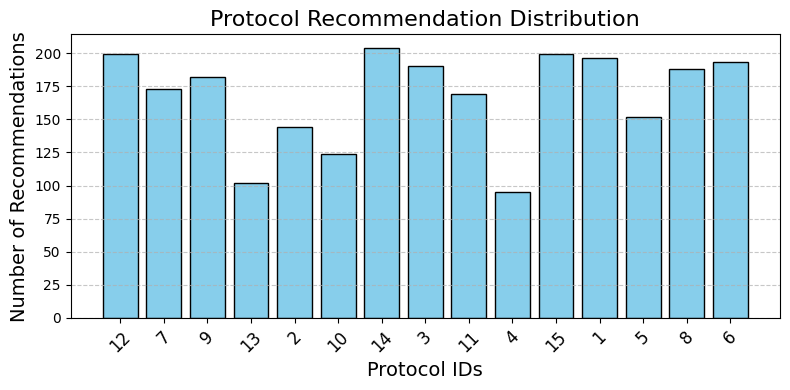

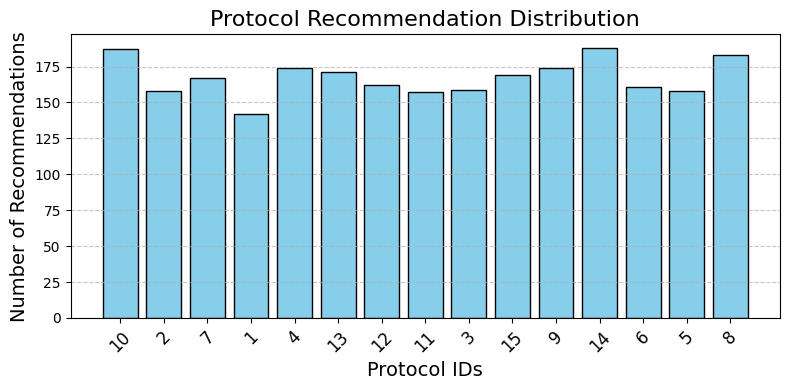

In [11]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_protocol_recommendation_distribution(patient):
    """
    Plots the distribution of protocol recommendations for a patient.

    Args:
        patient (Patient): Patient object containing recommendation history.
    """
    # Extract recommended IDs from recommendation history
    recommended_ids = np.concatenate([rec["recommended"] for rec in patient.recommendation_history])

    # Count occurrences of each protocol ID
    recommendation_counts = Counter(recommended_ids)

    # Extract protocol IDs and their counts for plotting
    protocol_ids, counts = zip(*recommendation_counts.items())

    # Plotting
    plt.figure(figsize=(8, 4))
    plt.bar(protocol_ids, counts, color='skyblue', edgecolor='black')
    plt.title("Protocol Recommendation Distribution", fontsize=16)
    plt.xlabel("Protocol IDs", fontsize=14)
    plt.ylabel("Number of Recommendations", fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Assuming `patient` is an instance of the Patient class with recommendation history
plot_protocol_recommendation_distribution(patient1)
plot_protocol_recommendation_distribution(patient2)

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Parameters for sampling
total_items = 15
sample_size = 5
num_samples = 1001

# Perform random sampling
samples = [np.random.choice(total_items, sample_size, replace=False) for _ in range(num_samples)]

# Flatten the samples into a single list for distribution analysis
flattened_samples = np.concatenate(samples)

# Create a DataFrame for visualization
df = pd.DataFrame(flattened_samples, columns=["Item Index"])

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="Item Index", palette="viridis", order=range(total_items))
plt.title("Distribution of Items in Random Sampling")
plt.xlabel("Item Index")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

2. Temporal Trends in Recommendations

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_temporal_trends(patient, ordered=True):
    """
    Plots a heatmap showing temporal trends in protocol recommendations.

    Args:
        patient (Patient): Patient object containing recommendation history.
    """
    # Extract recommendation history
    temporal_data = []
    for idx, recommendation in enumerate(patient.recommendation_history):
        for protocol_id in recommendation["recommended"]:
            temporal_data.append({"Day": idx + 1, "Protocol": protocol_id})

    # Convert to DataFrame
    df = pd.DataFrame(temporal_data)

    # Pivot table to count recommendations per session per protocol
    heatmap_data = df.pivot_table(
        index="Protocol",
        columns="Day",
        aggfunc="size",
        fill_value=0
    )

    if ordered:
        # Calculate row totals and sort by total sum
        heatmap_data["Total"] = heatmap_data.sum(axis=1)  # Add a column for row totals
        heatmap_data = heatmap_data.sort_values("Total", ascending=False)  # Sort by totals
        heatmap_data = heatmap_data.drop(columns="Total")  # Remove the totals column after sorting

    # Plot heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data, annot=False, fmt="d", cmap="YlGnBu", cbar_kws={"label": "Recommended"})
    plt.title("Temporal Trends in Protocol Recommendations", fontsize=16)
    plt.xlabel("Day", fontsize=14)
    plt.ylabel("Protocol", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

# Assuming `patient` is an instance of the Patient class with recommendation history
plot_temporal_trends(patient1)
plot_temporal_trends(patient2)

3. DM Progress Over Time

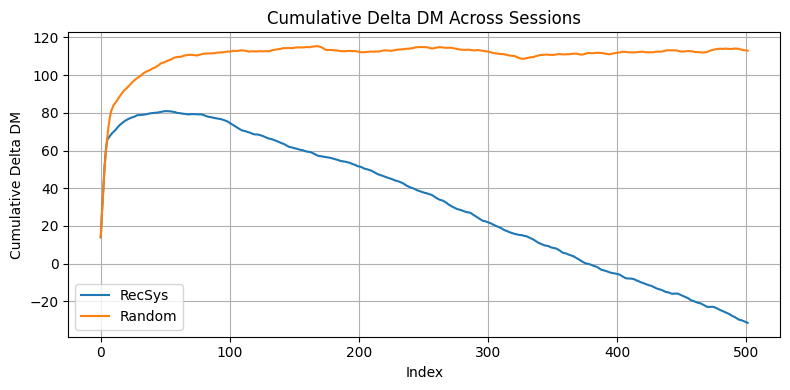

In [10]:
def cum_delta_dm(patient, label):
    cumulative_delta_dm = np.cumsum(np.array([sum(list(rec['delta_dm'].values())) for rec in patient.recommendation_history]))

    # Plotting cumulative delta_dm over time
    plt.plot(range(len(cumulative_delta_dm)), cumulative_delta_dm, linestyle='-', label=label)
    plt.xlabel('Index')
    plt.ylabel('Cumulative Delta DM')
    plt.title('Cumulative Delta DM Across Sessions')

plt.figure(figsize=(8, 4))
cum_delta_dm(patient1, "RecSys")
cum_delta_dm(patient2, "Random")
plt.legend()  # Add legend to the plot
plt.grid()
plt.tight_layout()
plt.show()

4. Cumulative number of DMs saturated

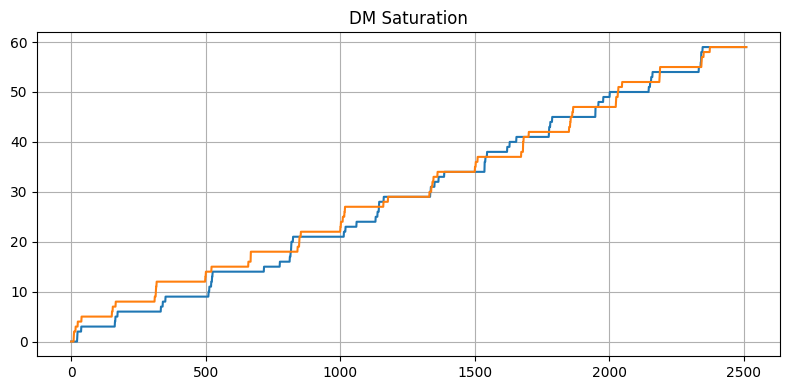

In [9]:
def cum_dms_saturated(patient):
    """
    Computes the cumulative number of DMs saturated over time.

    Args:
        patient: The patient object with sessions (grouped by protocol IDs) and DM ground truth.

    Returns:
        cumulative_saturation (list): The cumulative number of saturated DMs over time.
    """
    # Dictionary to track which DMs have already been counted as saturated
    saturated_tracker = {}

    # Initialize cumulative saturation list
    cumulative_saturation = []

    # Iterate over protocol sessions
    for protocol_id, sessions in patient.sessions.items():
        # Extract ground truth for the current protocol
        ground_truth = patient.dm_ground_truth.get(protocol_id)  # List[float]

        # Ensure ground_truth exists for this protocol
        if not ground_truth:
            continue

        for session in sessions:
            # Check if session has DMs
            if not session.dms:
                continue

            # Compare session DMs with ground truth
            for dm_index, dm_value in enumerate(session.dms):
                # Ensure we're within bounds of ground_truth
                if dm_index < len(ground_truth) and dm_value >= ground_truth[dm_index]:
                    # Only count if this DM hasn't been saturated before
                    if (protocol_id, dm_index) not in saturated_tracker:
                        saturated_tracker[(protocol_id, dm_index)] = True

            # Count the number of unique saturated DMs so far
            cumulative_saturation.append(len(saturated_tracker))

    return cumulative_saturation

plt.figure(figsize=(8, 4))
plt.title('DM Saturation')
plt.plot(cum_dms_saturated(patient1))
plt.plot(cum_dms_saturated(patient2))
plt.grid()
plt.tight_layout()
plt.show()

5. Probability distribution change across recommendations

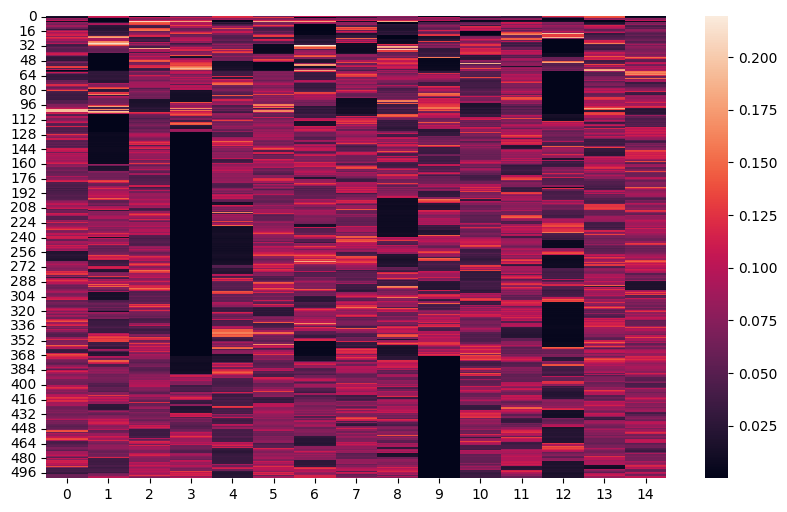

In [28]:
import seaborn as sns
prob_dists = [list(rec['probabilities'].values()) for rec in patient1.recommendation_history]
plt.figure(figsize=(10,6))
sns.heatmap(prob_dists)
plt.show()

In [56]:
from dataclasses import dataclass, asdict
import numpy as np
import pandas as pd

@dataclass
class Session:
    performance: float
    dms: float
    timestamp_start: int
    timestamp_end: int
    prescribed_duration: int

# Example list of sessions
sessions = [
    Session(performance=0.8, dms=1.2, timestamp_start=1620001234, timestamp_end=1620001534, prescribed_duration=6),
    Session(performance=0.9, dms=1.4, timestamp_start=1620002234, timestamp_end=1620002634, prescribed_duration=10),
]

df = pd.DataFrame(sessions)  # Assumes sessions is a list of dictionaries or dataclass instances
df['duration'] = (df['timestamp_end'] - df['timestamp_start']) / 60
df

,performance,dms,timestamp_start,timestamp_end,prescribed_duration,duration
0,0.8,1.2,1620001234,1620001534,6,5.000000
1,0.9,1.4,1620002234,1620002634,10,6.666667


In [63]:
df['duration'].sum() / df['prescribed_duration'].sum()

np.float64(0.7291666666666667)

In [61]:
(df['duration'] / df['prescribed_duration']).mean()

np.float64(0.75)

# DM Dynamics
Would be cool to:
- Validate DMs progression model against real data.
    - fit adjustment_factor (convergence time), dms_target, (?+ stability -> noise)
    - evalute data vs prediction
- Check if dms_target is can be assigned to user (demographics) clusters if any
- Extend model including i.e. fatigue `dms(n+1)=dmstarget​−(dmstarget​−dms(n))⋅(1−a)` for dm prediction

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize parameters
current_dms = [0.1, 0.2]
target_dms = [0.8, 0.9]
adjustment_factor = 0.1
noise_range = 0.05  # Noise will be in the range [-0.05, 0.05]

# Store dms
dms = [current_dms]
for session in range(51):
    delta = [target - current for target, current in zip(target_dms, current_dms)]
    # new_dms = [current + adjustment_factor * d for current, d in zip(current_dms, delta)]
    new_dms = [
        current + adjustment_factor * d + np.random.uniform(-noise_range, noise_range)
        for current, d in zip(current_dms, delta)
    ]
    current_dms = new_dms
    dms.append(current_dms)  # Append updated DMs to the list

# Convert to numpy array for easier plotting
dms = np.array(dms)

# Compute closed-form solution
n_sessions = len(dms)
n_values = np.arange(n_sessions)
# closed_form_dms = [
#     [
#         target - (target - current_0) * (1 - adjustment_factor) ** n
#         for target, current_0 in zip(target_dms, [0.1, 0.2])
#     ]
#     for n in n_values
# ]
closed_form_dms = [
    [
        target - (target - current_0) * (1 - adjustment_factor) ** n + np.random.uniform(-noise_range, noise_range)
        for target, current_0 in zip(target_dms, [0.1, 0.2])
    ]
    for n in n_values
]
closed_form_dms = np.array(closed_form_dms)

# Plot curves
plt.figure(figsize=(10, 6))

for i, (dm_series, label) in enumerate(zip(dms.T, ['DM1 (Iterative)', 'DM2 (Iterative)'])):
    plt.plot(n_values, dm_series, label=label, linestyle='-', marker='o')

# for i, (dm_series, label) in enumerate(zip(closed_form_dms.T, ['DM1 (Closed-Form)', 'DM2 (Closed-Form)'])):
#     plt.plot(n_values, dm_series, label=label, linestyle='--')

# Add horizontal lines for target DMs
for target_dm, label in zip(target_dms, ['DM1 Target', 'DM2 Target']):
    plt.axhline(y=target_dm, color='gray', linestyle=':', label=f'{label} (Target)')

plt.title("Comparison of Iterative and Closed-Form Solutions for DMs")
plt.xlabel("Session")
plt.ylabel("Difficulty Modulators (DMs)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter

# Initialize parameters
current_dms = [0.1, 0.2]
target_dms = [0.8, 0.9]
adjustment_factor = 0.1
noise_range = 0.05  # Noise will be in the range [-0.05, 0.05]

# Generate noisy observations
dms = [current_dms]
for session in range(51):
    delta = [target - current for target, current in zip(target_dms, current_dms)]
    new_dms = [
        current + adjustment_factor * d + np.random.uniform(-noise_range, noise_range)
        for current, d in zip(current_dms, delta)
    ]
    current_dms = new_dms
    dms.append(current_dms)

# Convert to numpy array
dms = np.array(dms)

# Define the Kalman filter
kf = KalmanFilter(initial_state_mean=[0.1, 0.2], n_dim_obs=2)

# Define the transition matrix and observation matrix
F = np.eye(2) * (1 - adjustment_factor)  # Incorporate adjustment_factor dynamics
G = adjustment_factor * np.array(target_dms)  # Target contribution to evolution
H = np.eye(2)  # Observations directly correspond to state

# Set the transition and observation matrices
kf.transition_matrices = F
kf.transition_offsets = G  # Add target contribution as offset
kf.observation_matrices = H

# Set the process and observation noise covariance matrices
kf.transition_covariance = np.eye(2) * 0.01  # Process noise
kf.observation_covariance = np.eye(2) * noise_range  # Observation noise

# Apply the Kalman filter
(smoothed_dms, _) = kf.smooth(dms)

# Plot results
plt.figure(figsize=(10, 6))

# Plot noisy observations
for i, (dm_series, label) in enumerate(zip(dms.T, ['DM1 (Noisy)', 'DM2 (Noisy)'])):
    plt.plot(dm_series, label=label, linestyle='-', marker='o', alpha=0.6)

# Plot Kalman-filtered DMs
for i, (dm_series, label) in enumerate(zip(smoothed_dms.T, ['DM1 (Filtered)', 'DM2 (Filtered)'])):
    plt.plot(dm_series, label=label, linestyle='--', linewidth=2)

# Add horizontal lines for target DMs
for target_dm, label in zip(target_dms, ['DM1 Target', 'DM2 Target']):
    plt.axhline(y=target_dm, color='gray', linestyle=':', label=f'{label} (Target)')

plt.title("Kalman Filter with Custom Transition Model for DMs")
plt.xlabel("Session")
plt.ylabel("Difficulty Modulators (DMs)")
plt.legend()
plt.grid(True)
plt.show()


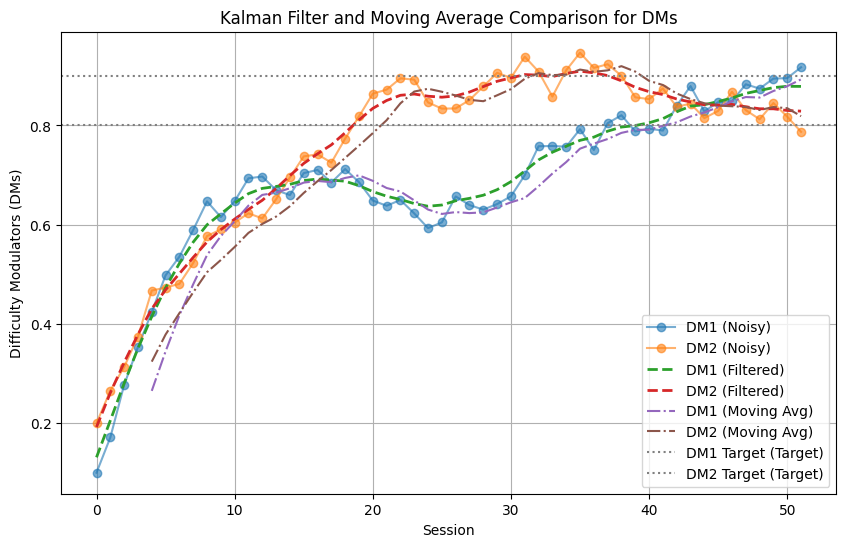

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter

# Initialize parameters
current_dms = [0.1, 0.2]
target_dms = [0.8, 0.9]
adjustment_factor = 0.1
noise_range = 0.05  # Noise will be in the range [-0.05, 0.05]

# Generate noisy observations
dms = [current_dms]
for session in range(51):
    delta = [target - current for target, current in zip(target_dms, current_dms)]
    new_dms = [
        current + adjustment_factor * d + np.random.uniform(-noise_range, noise_range)
        for current, d in zip(current_dms, delta)
    ]
    current_dms = new_dms
    dms.append(current_dms)

# Convert to numpy array
dms = np.array(dms)

# Define the Kalman filter
kf = KalmanFilter(initial_state_mean=[0.1, 0.2], n_dim_obs=2)

# Define the transition matrix and observation matrix
F = np.eye(2) * (1 - adjustment_factor)  # Incorporate adjustment_factor dynamics
G = adjustment_factor * np.array(target_dms)  # Target contribution to evolution
H = np.eye(2)  # Observations directly correspond to state

# Set the transition and observation matrices
kf.transition_matrices = F
kf.transition_offsets = G  # Add target contribution as offset
kf.observation_matrices = H

# Set the process and observation noise covariance matrices
kf.transition_covariance = np.eye(2) * 0.01  # Process noise
kf.observation_covariance = np.eye(2) * noise_range  # Observation noise

# Apply the Kalman filter
(smoothed_dms, _) = kf.smooth(dms)

# Calculate moving averages
window_size = 5  # Define the window size for the moving average
moving_averages = np.array([
    np.convolve(dms[:, i], np.ones(window_size) / window_size, mode='valid')
    for i in range(dms.shape[1])
]).T

# Plot results
plt.figure(figsize=(10, 6))

# Plot noisy observations
for i, (dm_series, label) in enumerate(zip(dms.T, ['DM1 (Noisy)', 'DM2 (Noisy)'])):
    plt.plot(dm_series, label=label, linestyle='-', marker='o', alpha=0.6)

# Plot Kalman-filtered DMs
for i, (dm_series, label) in enumerate(zip(smoothed_dms.T, ['DM1 (Filtered)', 'DM2 (Filtered)'])):
    plt.plot(dm_series, label=label, linestyle='--', linewidth=2)

# Plot Moving Average
for i, (dm_series, label) in enumerate(zip(moving_averages.T, ['DM1 (Moving Avg)', 'DM2 (Moving Avg)'])):
    plt.plot(range(window_size - 1, len(dm_series) + window_size - 1), dm_series, label=label, linestyle='-.')

# Add horizontal lines for target DMs
for target_dm, label in zip(target_dms, ['DM1 Target', 'DM2 Target']):
    plt.axhline(y=target_dm, color='gray', linestyle=':', label=f'{label} (Target)')

plt.title("Kalman Filter and Moving Average Comparison for DMs")
plt.xlabel("Session")
plt.ylabel("Difficulty Modulators (DMs)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter

# Generate noisy data with an upward trend
np.random.seed(42)
time = np.arange(0, 100)
true_trend = 0.5 * time + 10  # Underlying trend
observations = true_trend + np.random.normal(scale=10, size=len(time))  # Add noise

# Initialize Kalman Filter
kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)

# Define transition and observation matrices
kf = kf.em(observations, n_iter=10)  # Learn the parameters from data
(smoothed_state_means, _) = kf.smooth(observations)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(time, observations, label="Noisy Observations", alpha=0.6)
plt.plot(time, true_trend, label="True Trend", linestyle="--")
plt.plot(time, smoothed_state_means, label="Kalman Filter Estimate", color="red")
plt.legend()
plt.title("Kalman Filter for Trend Detection")
plt.show()


In [65]:
from datetime import datetime

class Session:
    def __init__(self, session_id, protocol_id, timestamp, data):
        self.session_id = session_id
        self.protocol_id = protocol_id
        self.timestamp = timestamp
        self.data = data

    def __repr__(self):
        return f"Session(id={self.session_id}, protocol={self.protocol_id}, time={self.timestamp})"

# Single dictionary with tuple keys
sessions_by_key = {}

# Add a session to the dictionary
def add_session(session):
    key = (session.protocol_id, session.timestamp.date())  # Tuple key: (protocol_id, date)
    if key not in sessions_by_key:
        sessions_by_key[key] = []
    sessions_by_key[key].append(session)

# Query sessions by protocol and date
def get_sessions(protocol_id=None, date=None):
    if protocol_id is None and date is None:
        # Return all sessions
        return [session for sessions in sessions_by_key.values() for session in sessions]
    elif protocol_id is None:
        # Return sessions for a specific date
        return [session for (pid, d), sessions in sessions_by_key.items() if d == date for session in sessions]
    elif date is None:
        # Return sessions for a specific protocol
        return [session for (pid, d), sessions in sessions_by_key.items() if pid == protocol_id for session in sessions]
    else:
        # Return sessions for a specific protocol and date
        return sessions_by_key.get((protocol_id, date), [])

# Example usage
session1 = Session("s1", "p1", datetime(2024, 1, 1, 9, 0), {"adherence": 0.9})
session2 = Session("s2", "p1", datetime(2024, 1, 1, 10, 30), {"adherence": 0.8})
session3 = Session("s3", "p2", datetime(2024, 1, 1, 15, 0), {"adherence": 0.7})
session4 = Session("s4", "p1", datetime(2024, 1, 2, 9, 30), {"adherence": 0.85})
session5 = Session("s5", "p2", datetime(2024, 1, 2, 11, 0), {"adherence": 0.95})

# Add sessions
for session in [session1, session2, session3, session4, session5]:
    add_session(session)

# Query
print("All sessions:", get_sessions())
print("Sessions for protocol p1:", get_sessions(protocol_id="p1"))
print("Sessions on 2024-01-01:", get_sessions(date=datetime(2024, 1, 1).date()))
print("Sessions for protocol p1 on 2024-01-01:", get_sessions(protocol_id="p1", date=datetime(2024, 1, 1).date()))


All sessions: [Session(id=s1, protocol=p1, time=2024-01-01 09:00:00), Session(id=s2, protocol=p1, time=2024-01-01 10:30:00), Session(id=s3, protocol=p2, time=2024-01-01 15:00:00), Session(id=s4, protocol=p1, time=2024-01-02 09:30:00), Session(id=s5, protocol=p2, time=2024-01-02 11:00:00)]
Sessions for protocol p1: [Session(id=s1, protocol=p1, time=2024-01-01 09:00:00), Session(id=s2, protocol=p1, time=2024-01-01 10:30:00), Session(id=s4, protocol=p1, time=2024-01-02 09:30:00)]
Sessions on 2024-01-01: [Session(id=s1, protocol=p1, time=2024-01-01 09:00:00), Session(id=s2, protocol=p1, time=2024-01-01 10:30:00), Session(id=s3, protocol=p2, time=2024-01-01 15:00:00)]
Sessions for protocol p1 on 2024-01-01: [Session(id=s1, protocol=p1, time=2024-01-01 09:00:00), Session(id=s2, protocol=p1, time=2024-01-01 10:30:00)]
